In [1]:
#!/usr/bin/env python3
"""
Compare seatbelt detection results between algorithm output and ground truth labels.
"""

import json
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from typing import List, Dict


In [15]:
def load_algorithm_results(directory: str = "seatbelt_result") -> List[str]:
    """
    Load seat1 seatbelt states from all JSON files in the algorithm results directory.

    Returns:
        List of seatbelt states for seat1 in temporal order
    """
    seatbelt_dir = Path(directory)
    json_files = sorted(seatbelt_dir.glob("img_*.json"))

    print(f"Loading algorithm results from {len(json_files)} files...")

    seat1_states = []

    for json_file in json_files:
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)

            # Extract seat1 seatbelt state
            seatbelt_info = data['body'][0]['seatbelt']
            seat1_state = seatbelt_info['seat2']['state']
            seat1_states.append(seat1_state)

        except Exception as e:
            print(f"Error processing {json_file.name}: {e}")
            seat1_states.append('unknown')

    print(f"Loaded {len(seat1_states)} algorithm results")
    return seat1_states


def load_ground_truth(filepath: str = "5안전벨트.json") -> List[str]:
    """
    Load ground truth seatbelt labels from key frames and reconstruct for all frames.
    
    The JSON file contains key frames where state transitions occur.
    We reconstruct the full timeline by propagating states between key frames.
    
    Mapping from ground truth to algorithm states:
    - 1 (none) -> "unbelt"
    - 2 (good) -> "belt" 
    - 3 (bad) -> "misuse"
    - 4 (invalid) -> "unbbelt"
    
    Returns:
        List of seatbelt states in temporal order for all frames
    """
    print(f"Loading ground truth from {filepath}...")
    
    with open(filepath, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # Get key frames and mappings
    frames_data = data.get('frames', {})
    metadata = data.get('metadata', {})
    total_frames = metadata.get('total_frames', 1792)
    
    # Value mapping from ground truth to algorithm states
    value_map = {
        1: "unbelt",   # none -> unbelt
        2: "belt",     # good -> belt  
        3: "misuse",   # bad -> misuse
        4: "unbbelt"   # invalid -> unbbelt
    }
    
    # Extract frame numbers from filenames and sort them
    key_frames = []
    for filename, frame_data in frames_data.items():
        # Extract frame number from filename (e.g., "img_20250918_164843_2560_1984_1E_00000.bmp" -> 0)
        frame_num_str = filename.split('_')[-1].replace('.bmp', '')
        frame_num = int(frame_num_str)
        state_value = frame_data['driver_seatbelt'][0]
        state = value_map.get(state_value, 'unknown')
        key_frames.append((frame_num, state))
    
    # Sort key frames by frame number
    key_frames.sort(key=lambda x: x[0])
    
    print(f"Found {len(key_frames)} key frames with state transitions")
    for frame_num, state in key_frames:
        print(f"  Frame {frame_num:5d}: {state}")
    
    # Reconstruct full timeline by propagating states between key frames
    ground_truth_states = []
    
    for i in range(total_frames):
        # Find the appropriate state for this frame
        state = 'unknown'
        
        # Find the last key frame before or at this frame
        for frame_num, frame_state in reversed(key_frames):
            if i >= frame_num:
                state = frame_state
                break
        
        # If no key frame found before this frame, use the first key frame's state
        if state == 'unknown' and key_frames:
            state = key_frames[0][1]
            
        ground_truth_states.append(state)
    
    print(f"Reconstructed {len(ground_truth_states)} ground truth labels for all frames")
    
    # Print state distribution
    state_counts = {}
    for state in ground_truth_states:
        state_counts[state] = state_counts.get(state, 0) + 1
    print("\nGround truth state distribution:")
    for state, count in sorted(state_counts.items()):
        percentage = count / len(ground_truth_states) * 100
        print(f"  {state:8s}: {count:5d} ({percentage:5.1f}%)")
    
    return ground_truth_states


def align_sequences(algo_states: List[str], gt_states: List[str]) -> tuple:
    """
    Align two sequences by resampling to match lengths.

    Args:
        algo_states: Algorithm detection results (~1800 samples)
        gt_states: Ground truth labels (~900 samples)

    Returns:
        Tuple of (aligned_algo, aligned_gt) with same length
    """
    algo_len = len(algo_states)
    gt_len = len(gt_states)

    print(f"\nAligning sequences: Algorithm={algo_len}, Ground Truth={gt_len}")

    # Resample ground truth to match algorithm length
    if gt_len > 0 and algo_len > 0:
        # Create indices for resampling
        gt_indices = np.linspace(0, gt_len - 1, algo_len)

        # Resample ground truth using nearest neighbor
        aligned_gt = []
        for idx in gt_indices:
            nearest_idx = int(np.round(idx))
            aligned_gt.append(gt_states[nearest_idx])

        return algo_states, aligned_gt

    return algo_states, gt_states


def calculate_agreement(states1: List[str], states2: List[str]) -> Dict:
    """
    Calculate agreement metrics between two state sequences.

    Returns:
        Dictionary with agreement statistics
    """
    if len(states1) != len(states2):
        print("Warning: Sequences have different lengths!")
        min_len = min(len(states1), len(states2))
        states1 = states1[:min_len]
        states2 = states2[:min_len]

    # Calculate overall agreement
    matches = sum(1 for s1, s2 in zip(states1, states2) if s1 == s2)
    total = len(states1)
    agreement_rate = (matches / total * 100) if total > 0 else 0

    # Calculate confusion matrix
    unique_states = sorted(set(states1 + states2))
    confusion = pd.DataFrame(0, index=unique_states, columns=unique_states)

    for s1, s2 in zip(states1, states2):
        confusion.loc[s1, s2] += 1

    # Calculate per-state accuracy
    state_accuracy = {}
    for state in unique_states:
        true_positives = confusion.loc[state, state]
        total_gt = confusion.loc[state, :].sum()
        accuracy = (true_positives / total_gt * 100) if total_gt > 0 else 0
        state_accuracy[state] = accuracy

    return {
        'agreement_rate': agreement_rate,
        'matches': matches,
        'total': total,
        'confusion_matrix': confusion,
        'state_accuracy': state_accuracy
    }


def visualize_comparison(algo_states: List[str], gt_states: List[str]):
    """
    Create visualizations comparing algorithm results with ground truth.
    """
    # Convert states to numeric for visualization
    state_to_num = {
        'belt': 2,
        'unbelt': 1,
        'misuse': 3,
        'unbbelt': 0,
        'unknown': -1
    }

    algo_numeric = [state_to_num.get(s, -1) for s in algo_states]
    gt_numeric = [state_to_num.get(s, -1) for s in gt_states]

    # Create time axis
    time_points = np.arange(len(algo_states))

    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=(15, 10))

    # Plot 1: Algorithm results
    ax1 = axes[0]
    ax1.plot(time_points, algo_numeric, 'b-', linewidth=0.8, alpha=0.7, label='Algorithm')
    ax1.set_ylabel('State')
    ax1.set_title('Algorithm Detection Results')
    ax1.set_yticks([0, 1, 2, 3])
    ax1.set_yticklabels(['unbbelt', 'unbelt', 'belt', 'misuse'])
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([0, len(algo_states)])

    # Plot 2: Ground truth
    ax2 = axes[1]
    ax2.plot(time_points, gt_numeric, 'g-', linewidth=0.8, alpha=0.7, label='Ground Truth')
    ax2.set_ylabel('State')
    ax2.set_title('Ground Truth Labels (Resampled)')
    ax2.set_yticks([0, 1, 2, 3])
    ax2.set_yticklabels(['unbbelt', 'unbelt', 'belt', 'misuse'])
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([0, len(algo_states)])

    # Plot 3: Difference/Agreement
    ax3 = axes[2]
    agreement = [1 if a == g else 0 for a, g in zip(algo_states, gt_states)]

    # Create colored background for agreement/disagreement regions
    for i in range(len(agreement) - 1):
        if agreement[i] == 1:
            ax3.axvspan(i, i+1, alpha=0.3, color='green')
        else:
            ax3.axvspan(i, i+1, alpha=0.3, color='red')

    ax3.plot(time_points, agreement, 'k-', linewidth=0.5, alpha=0.5)
    ax3.set_ylabel('Agreement')
    ax3.set_xlabel('Time Index')
    ax3.set_title('Agreement Between Algorithm and Ground Truth (Green=Match, Red=Mismatch)')
    ax3.set_yticks([0, 1])
    ax3.set_yticklabels(['Disagree', 'Agree'])
    ax3.set_xlim([0, len(algo_states)])
    ax3.set_ylim([-0.1, 1.1])

    plt.tight_layout()
    plt.show()

    # Create state distribution comparison
    fig2, axes2 = plt.subplots(1, 2, figsize=(12, 5))

    # Count states
    algo_counts = pd.Series(algo_states).value_counts()
    gt_counts = pd.Series(gt_states).value_counts()

    # Ensure all states are represented
    all_states = sorted(set(algo_states + gt_states))
    algo_counts = algo_counts.reindex(all_states, fill_value=0)
    gt_counts = gt_counts.reindex(all_states, fill_value=0)

    # Plot distributions
    x_pos = np.arange(len(all_states))
    width = 0.35

    ax = axes2[0]
    ax.bar(x_pos - width/2, algo_counts.values, width, label='Algorithm', color='blue', alpha=0.7)
    ax.bar(x_pos + width/2, gt_counts.values, width, label='Ground Truth', color='green', alpha=0.7)
    ax.set_xlabel('State')
    ax.set_ylabel('Count')
    ax.set_title('State Distribution Comparison')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(all_states, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot percentage distribution
    ax2 = axes2[1]
    algo_pct = (algo_counts / algo_counts.sum() * 100)
    gt_pct = (gt_counts / gt_counts.sum() * 100)

    ax2.bar(x_pos - width/2, algo_pct.values, width, label='Algorithm', color='blue', alpha=0.7)
    ax2.bar(x_pos + width/2, gt_pct.values, width, label='Ground Truth', color='green', alpha=0.7)
    ax2.set_xlabel('State')
    ax2.set_ylabel('Percentage (%)')
    ax2.set_title('State Distribution Comparison (Percentage)')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(all_states, rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [16]:

"""Main function to run the comparison."""
print("="*60)
print("SEATBELT DETECTION COMPARISON")
print("="*60)

# Load algorithm results
algo_states = load_algorithm_results("seatbelt_result")

# Load ground truth
gt_states = load_ground_truth("./5안전벨트.json")


SEATBELT DETECTION COMPARISON
Loading algorithm results from 1792 files...
Loaded 1792 algorithm results
Loading ground truth from ./5안전벨트.json...
Found 7 key frames with state transitions
  Frame     0: unbelt
  Frame   513: unbbelt
  Frame   593: belt
  Frame   932: unbbelt
  Frame   972: misuse
  Frame  1343: unbbelt
  Frame  1386: misuse
Reconstructed 1792 ground truth labels for all frames

Ground truth state distribution:
  belt    :   339 ( 18.9%)
  misuse  :   777 ( 43.4%)
  unbbelt :   163 (  9.1%)
  unbelt  :   513 ( 28.6%)



Aligning sequences: Algorithm=1792, Ground Truth=1792

AGREEMENT METRICS

Overall Agreement: 88.06% (1578/1792)

Per-State Accuracy:
  belt    :  74.83%
  misuse  :  94.22%
  unbbelt :   0.00%
  unbelt  :  90.28%
  unknown :   0.00%

Confusion Matrix (Rows=Algorithm, Columns=Ground Truth):
         belt  misuse  unbbelt  unbelt  unknown
belt      333      11      101       0        0
misuse      6     734       37       2        0
unbbelt     0       0        0       0        0
unbelt      0      30       25     511        0
unknown     0       2        0       0        0

Generating visualizations...


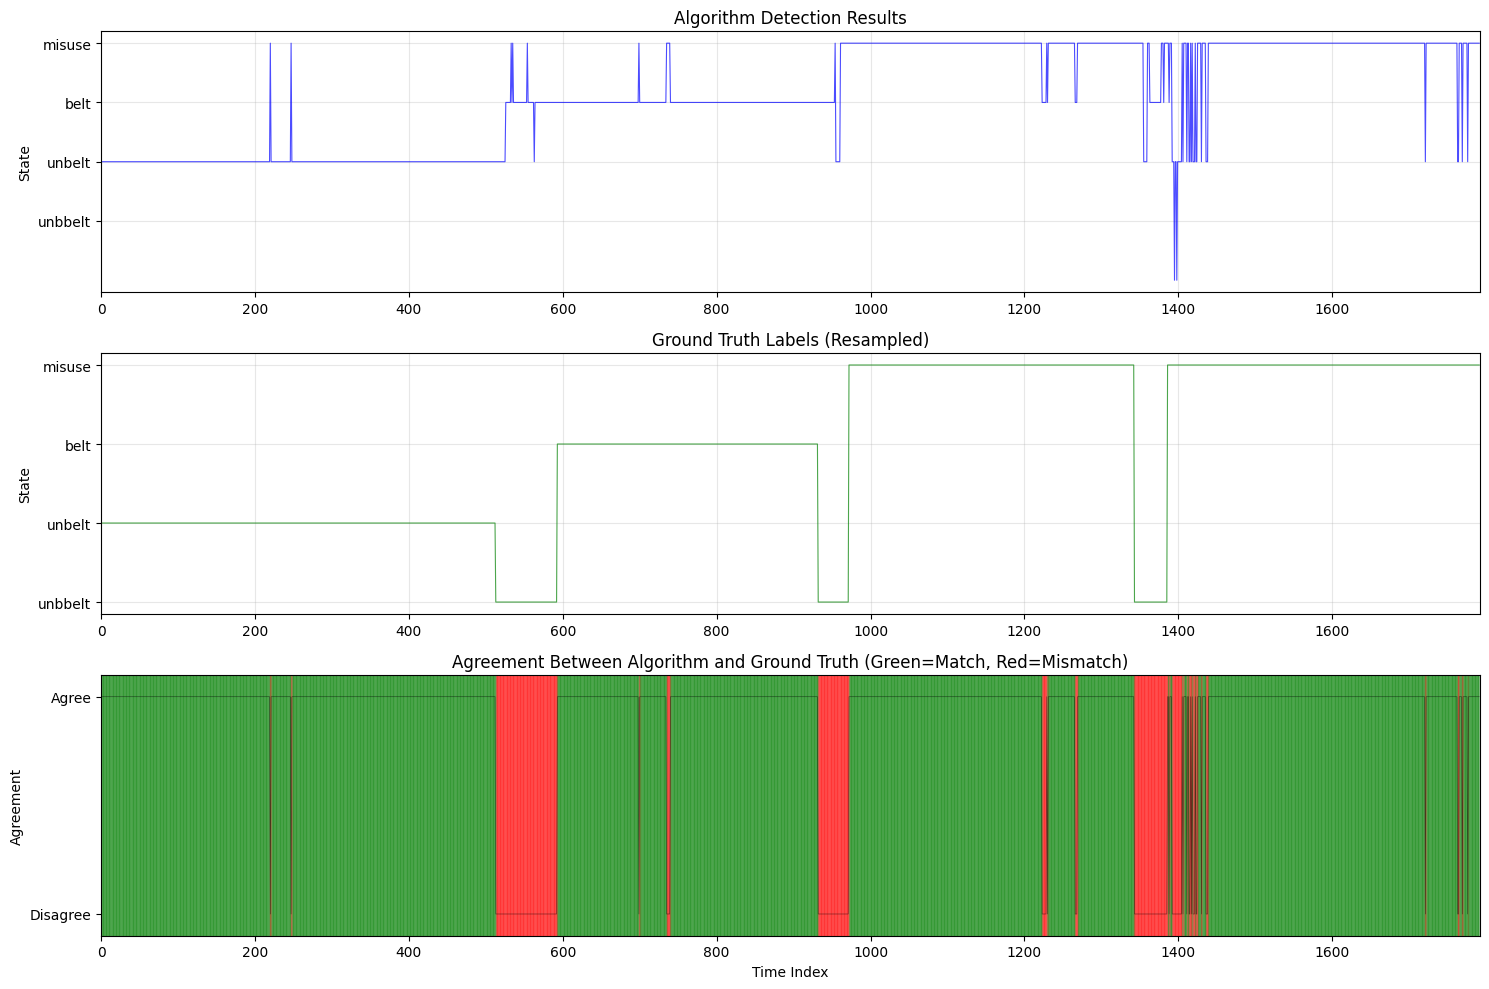

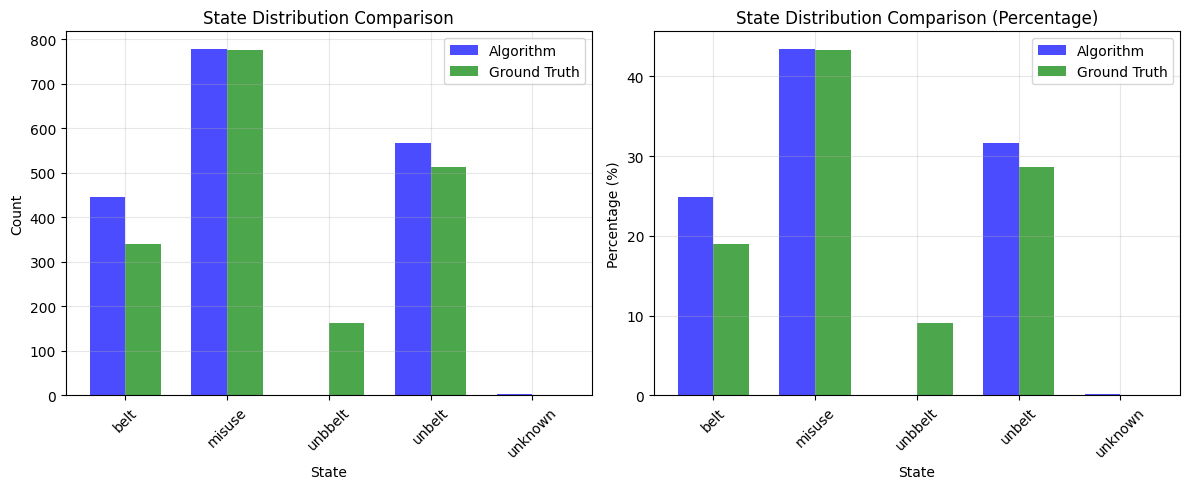


Comparison complete!


In [17]:

# Align sequences
algo_aligned, gt_aligned = align_sequences(algo_states, gt_states)

# Calculate agreement metrics
print("\n" + "="*60)
print("AGREEMENT METRICS")
print("="*60)

metrics = calculate_agreement(algo_aligned, gt_aligned)

print(f"\nOverall Agreement: {metrics['agreement_rate']:.2f}% ({metrics['matches']}/{metrics['total']})")

print("\nPer-State Accuracy:")
for state, accuracy in sorted(metrics['state_accuracy'].items()):
    print(f"  {state:8s}: {accuracy:6.2f}%")

print("\nConfusion Matrix (Rows=Algorithm, Columns=Ground Truth):")
print(metrics['confusion_matrix'])

# Visualize comparison
print("\nGenerating visualizations...")
visualize_comparison(algo_aligned, gt_aligned)

print("\n" + "="*60)
print("Comparison complete!")
print("="*60)
